# Functions to extract information from IFCB file names and process them into a pandas DF with information for Date, Time, and Instrument

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_distributions(df, suptitle="Data Distributions", save_path=None, log_scale=False, log_base=10):
    """
    Plots the distributions of dates, times, and instruments from the DataFrame.
    Optionally saves the plots to a file.

    Parameters:
    df (DataFrame): A pandas DataFrame containing 'Date', 'Time', and 'Instrument' columns.
    suptitle (str): The super title for the combined plots.
    save_path (str): The file path to save the plot (e.g., "output.png"). If None, the plot won't be saved.
    log_scale (bool): If True, the y-axis will be in log scale.
    log_base (int): The base of the logarithm for the y-axis if log_scale is True.

    Returns:
    fig, axs: The figure and axes objects for further customization.
    """
    # Convert 'Date' column to datetime if not already in that format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Create figure and axes
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    fig.suptitle(suptitle, fontsize=16)

    # Plot 1: Distribution of Dates
    df['Date'].value_counts().sort_index().plot(kind='bar', ax=axs[0])
    axs[0].set_title('Distribution of Dates')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Frequency')
    axs[0].tick_params(axis='x', rotation=90)
    if log_scale:
        axs[0].set_yscale('log', base=log_base)
        axs[0].set_title(f'Distribution of Dates (Log Scale base {log_base})')

    # Plot 2: Distribution of Times (Hour of Day)
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
    df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour

    # Create a series with all hours of the day
    all_hours = pd.Series(range(24), name='Hour')

    # Count occurrences of each hour and reindex to include all hours
    hour_counts = df['Hour'].value_counts().sort_index().reindex(all_hours, fill_value=0)

    hour_counts.plot(kind='bar', ax=axs[1])
    axs[1].set_title('Distribution of Times (Hour of the Day)')
    axs[1].set_xlabel('Hour of the Day')
    axs[1].set_ylabel('Frequency')
    axs[1].tick_params(axis='x', rotation=90)
    # if log_scale:
    #     axs[1].set_yscale('log', base=log_base)

    # Plot 3: Distribution of Instruments
    df['Instrument'].value_counts().sort_index().plot(kind='bar', ax=axs[2])
    axs[2].set_title('Distribution of Instruments')
    axs[2].set_xlabel('Instrument')
    axs[2].set_ylabel('Frequency')
    # if log_scale:
    #     axs[2].set_yscale('log', base=log_base)

    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    # Show the plot
    plt.show()

    return fig, axs


In [2]:
import os
import re
import pandas as pd
from datetime import datetime

def extract_info(filename):
    """
    Function to extract date, time, and IFCB number from filename
    Date will be in date format, time will be in time format, and instrument will be an integer

    Files should follow one of the formats:
    1. "D20120415T065129_IFCB010_00250" where the date is 04-15-2012, time is 06:51:29 UTC, and instrument is #10
    2. "IFCB1_2012_269_132047_00102.png" where the instrument is 1, year is 2012, julian date is 269, and time is 13:20:47
    """
    if filename.startswith('D'):
        date_str = filename[1:9]
        time_str = filename[10:16]
        ifcb_number = filename[21:24]

        date = datetime.strptime(date_str, "%Y%m%d").date()
        time = datetime.strptime(time_str, "%H%M%S").time()
        instrument = int(ifcb_number)
    else:
        parts = filename.split('_')
        instrument = int(parts[0][4:])
        year = int(parts[1])
        julian_date = int(parts[2])
        time_str = parts[3]

        date = datetime.strptime(f'{year}-{julian_date}', '%Y-%j').date()
        time = datetime.strptime(time_str, "%H%M%S").time()

    return date, time, instrument

def process_files_in_directory(directory_path):
    """
    Processes files in a directory, filtering those that match specific filename patterns,
    extracting relevant information, and organizing it into a DataFrame.

    Parameters:
    directory_path (str): The path of the folder containing the files.

    Returns:
    DataFrame: A pandas DataFrame with the extracted information (Date, Time, Instrument).
    """
    # Define the expected patterns
    pattern1 = re.compile(r'^D\d{8}T\d{6}_IFCB\d{3}_\d{5}\.png$')
    pattern2 = re.compile(r'^IFCB\d_\d{4}_\d{3}_\d{6}_\d{5}\.png$')
    
    try:
        # List files in the directory
        dir_list = os.listdir(directory_path)

        # Filter files that do not match either pattern
        different_format_files = [file for file in dir_list if not (pattern1.match(file) or pattern2.match(file))]
        print(f"Files that have alternative formats:", different_format_files)
        # Calculate the percentage of files that don't match the expected formats
        total_files = len(dir_list)
        percent_different_format = (len(different_format_files) / total_files) * 100
        print(f"Percentage of files that don't match the expected formats: {percent_different_format:.2f}%")

        # Remove files in different_format_files from dir_list
        dir_list = [file for file in dir_list if file not in different_format_files]

        # Extract information from the remaining files
        data = [extract_info(file) for file in dir_list]

        # Create a DataFrame
        df = pd.DataFrame(data, columns=['Date', 'Time', 'Instrument'])
        return df

    except FileNotFoundError:
        print(f"The folder {directory_path} does not exist.")
        return None

# Ex usage
#df = process_files_in_directory("path")
#print(df)


# Investigating temporal / instrument distribution in these training sets:



- Akashowio
- Alexandrium Catenella
- Dinophysis
- Dinophysis acuminata
- Fragillariopsis - NOT IN HABLAB_20220819
- Gonyaulax
- Kryptoperidinium triquetra
- margalefidinium
- Mesodinium
- Rhizosolenia
- Scrippsiella
- Thalassiosira
- Warnowia

## Akashowio



Files that have alternative formats: ['Confounded', 'Extra', 'Mistakes', '.DS_Store']
Percentage of files that don't match the expected formats: 11.43%
Unique IFCBs: [109   1]
Plot saved to /Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/akashowio.png


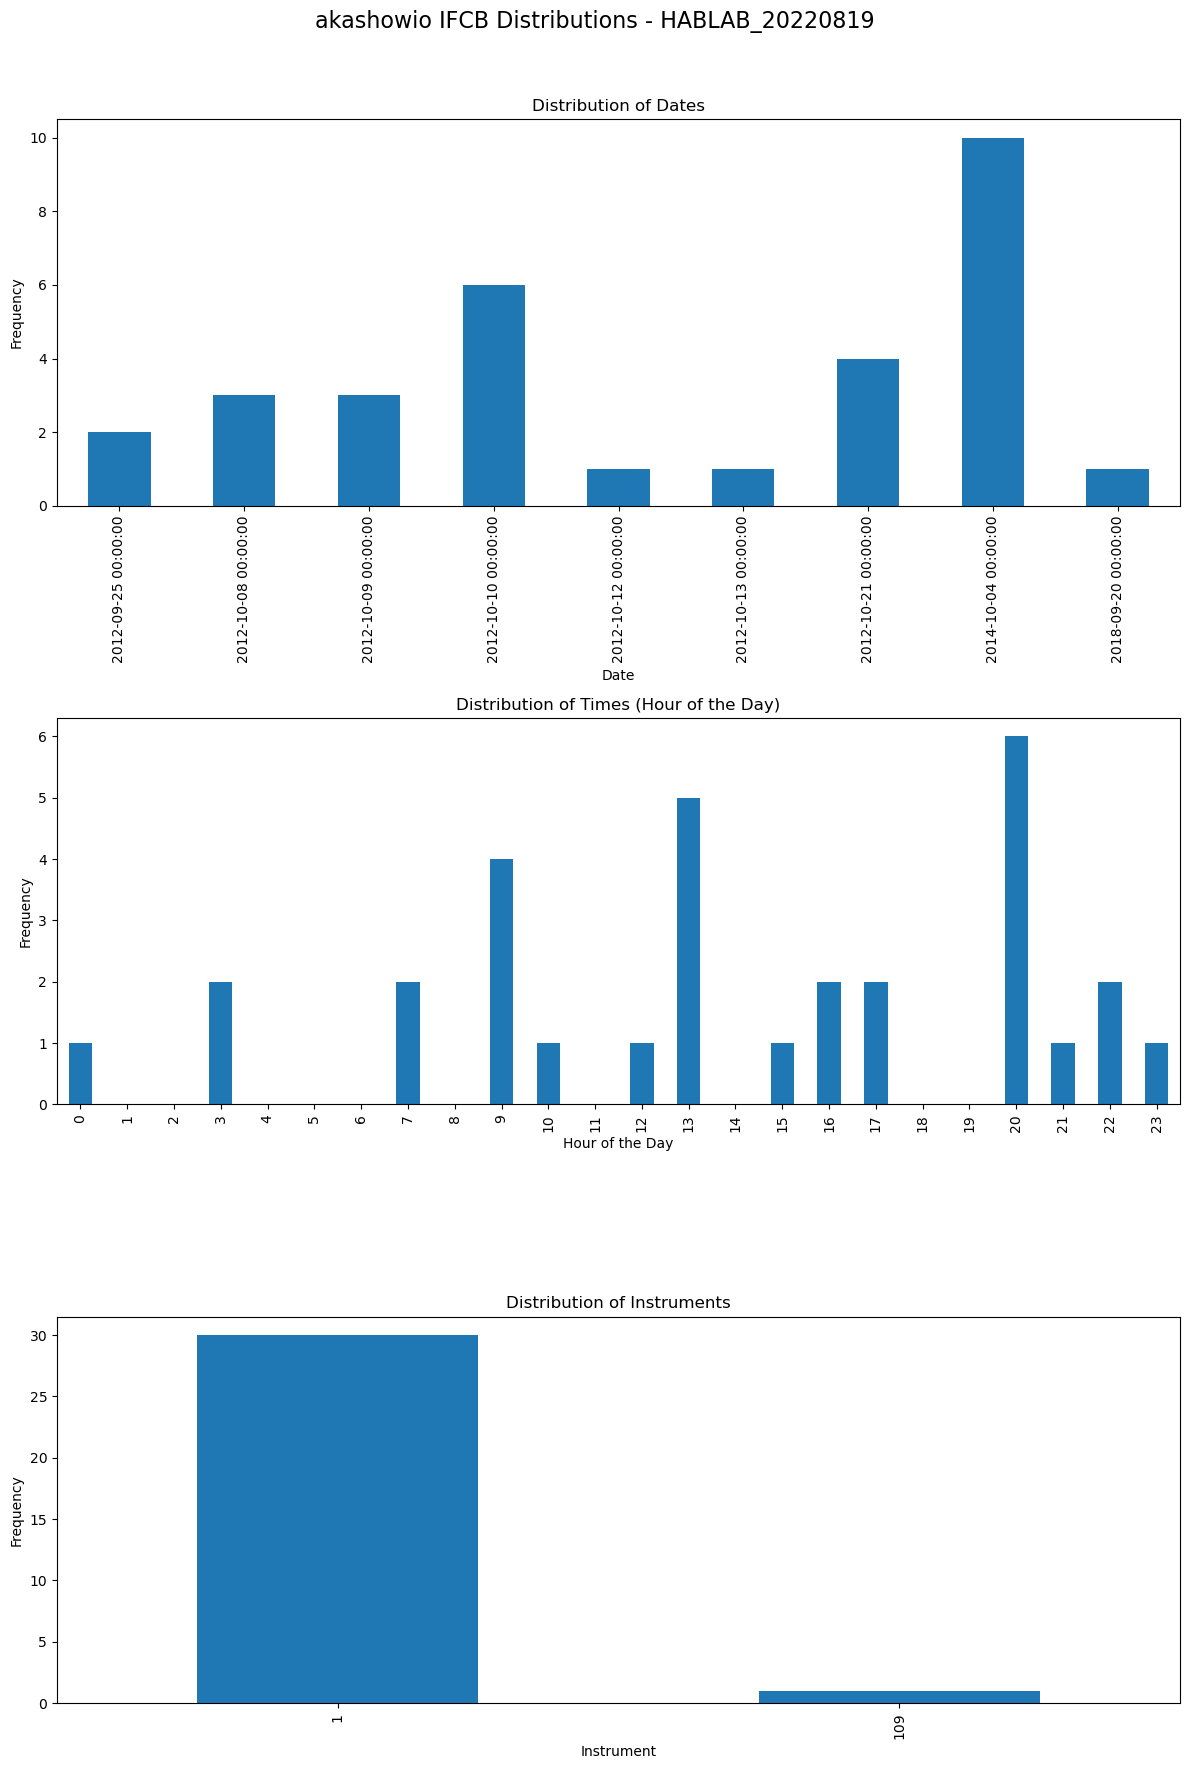

(<Figure size 1200x1800 with 3 Axes>,
 array([<Axes: title={'center': 'Distribution of Dates'}, xlabel='Date', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Times (Hour of the Day)'}, xlabel='Hour of the Day', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Instruments'}, xlabel='Instrument', ylabel='Frequency'>],
       dtype=object))

In [3]:
akashowio_path = "/Volumes/Vortex/cnn/training_sets/IFCB/HABLAB_20220819/Akashiwo"
akashowio = process_files_in_directory(akashowio_path)
print("Unique IFCBs:", akashowio['Instrument'].unique())
akashowio_save = "/Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/akashowio.png"
plot_distributions(akashowio, suptitle="akashowio IFCB Distributions - HABLAB_20220819", save_path=akashowio_save)

## Alexandrium catenella

Files that have alternative formats: []
Percentage of files that don't match the expected formats: 0.00%
Unique IFCBs: [ 10 101   1   5]
Plot saved to /Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/Alexandrium_catenella.png


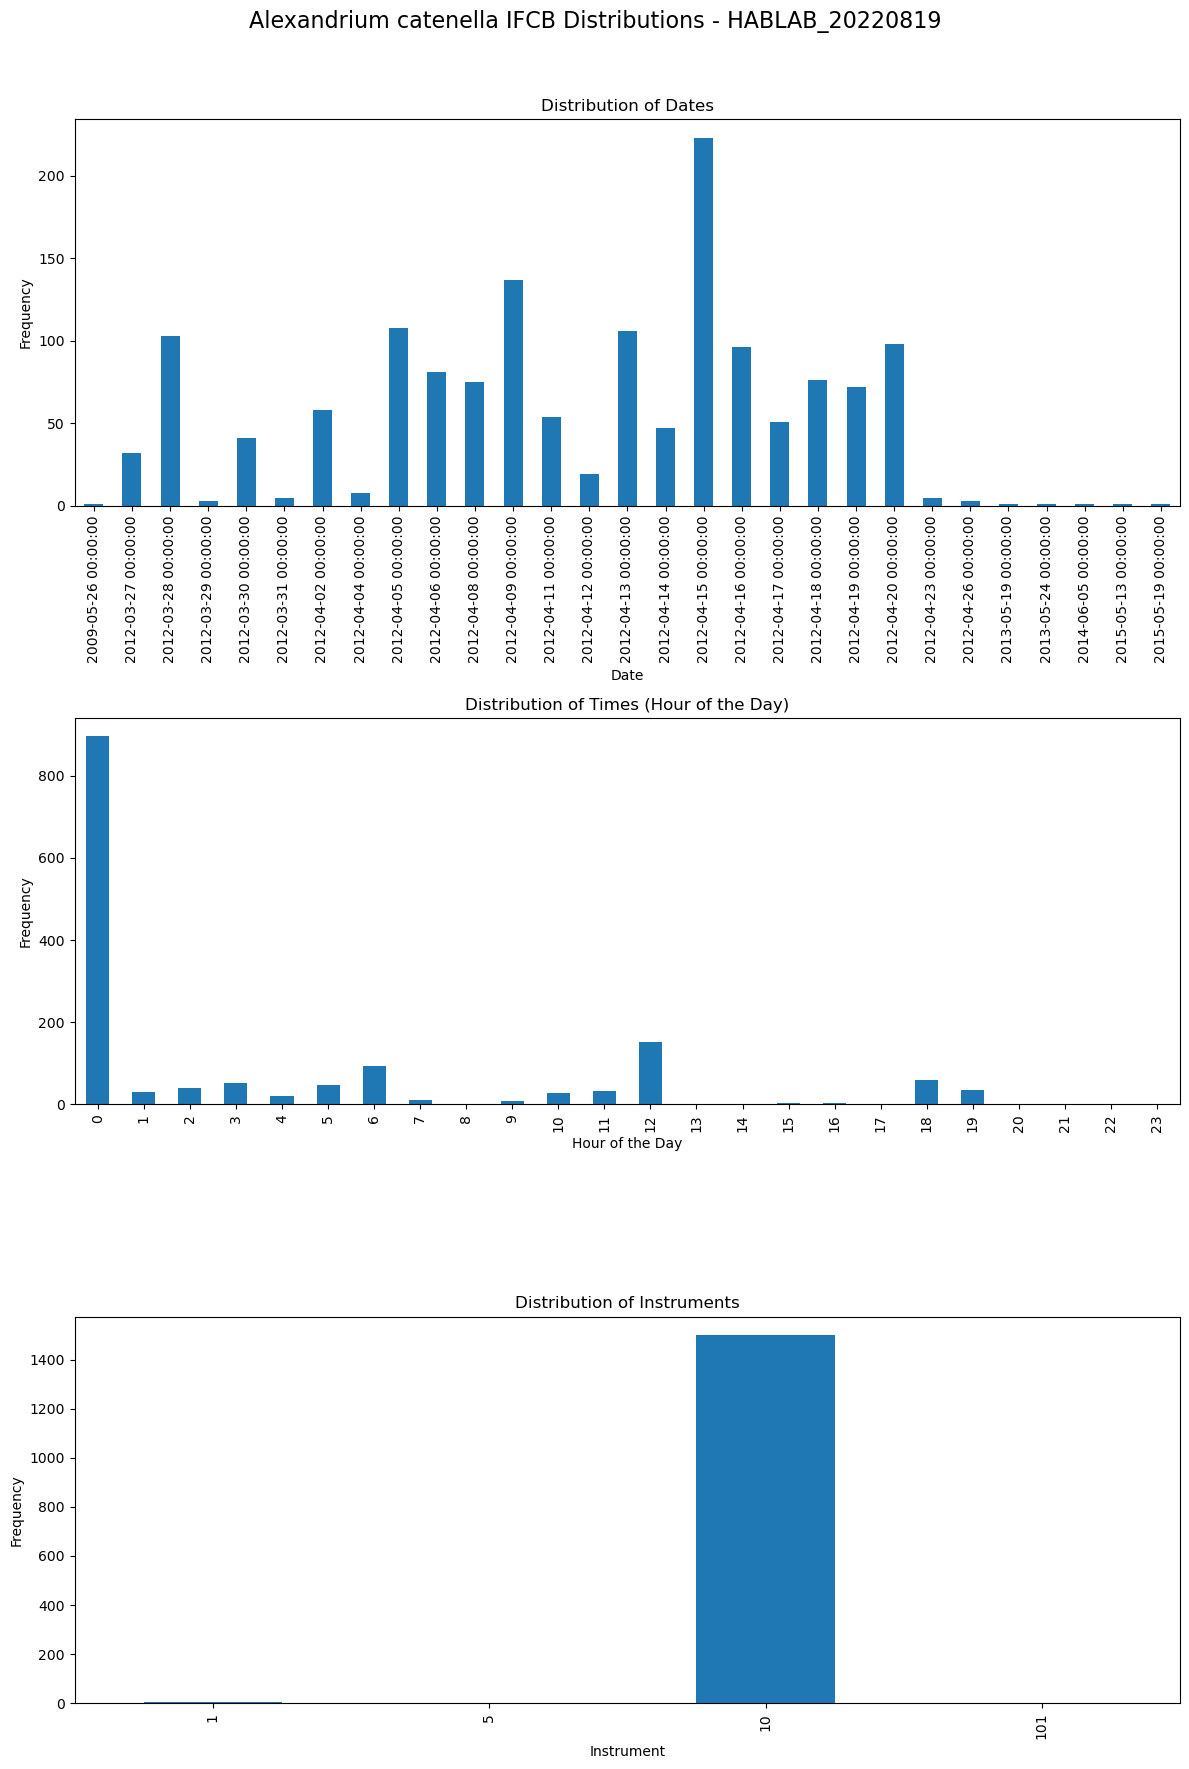

(<Figure size 1200x1800 with 3 Axes>,
 array([<Axes: title={'center': 'Distribution of Dates'}, xlabel='Date', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Times (Hour of the Day)'}, xlabel='Hour of the Day', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Instruments'}, xlabel='Instrument', ylabel='Frequency'>],
       dtype=object))

In [4]:

alex_path = "/Volumes/Vortex/cnn/training_sets/IFCB/HABLAB_20220819/Alexandrium_catenella"
alex = process_files_in_directory(alex_path)
print("Unique IFCBs:", alex['Instrument'].unique())
alex_save = "/Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/Alexandrium_catenella.png"
plot_distributions(alex, suptitle="Alexandrium catenella IFCB Distributions - HABLAB_20220819", save_path=alex_save)

## Dinophysis

Files that have alternative formats: ['.DS_Store']
Percentage of files that don't match the expected formats: 1.45%
Unique IFCBs: [ 10  14 101 102 109 129   1   5]
Plot saved to /Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/dinophysis.png


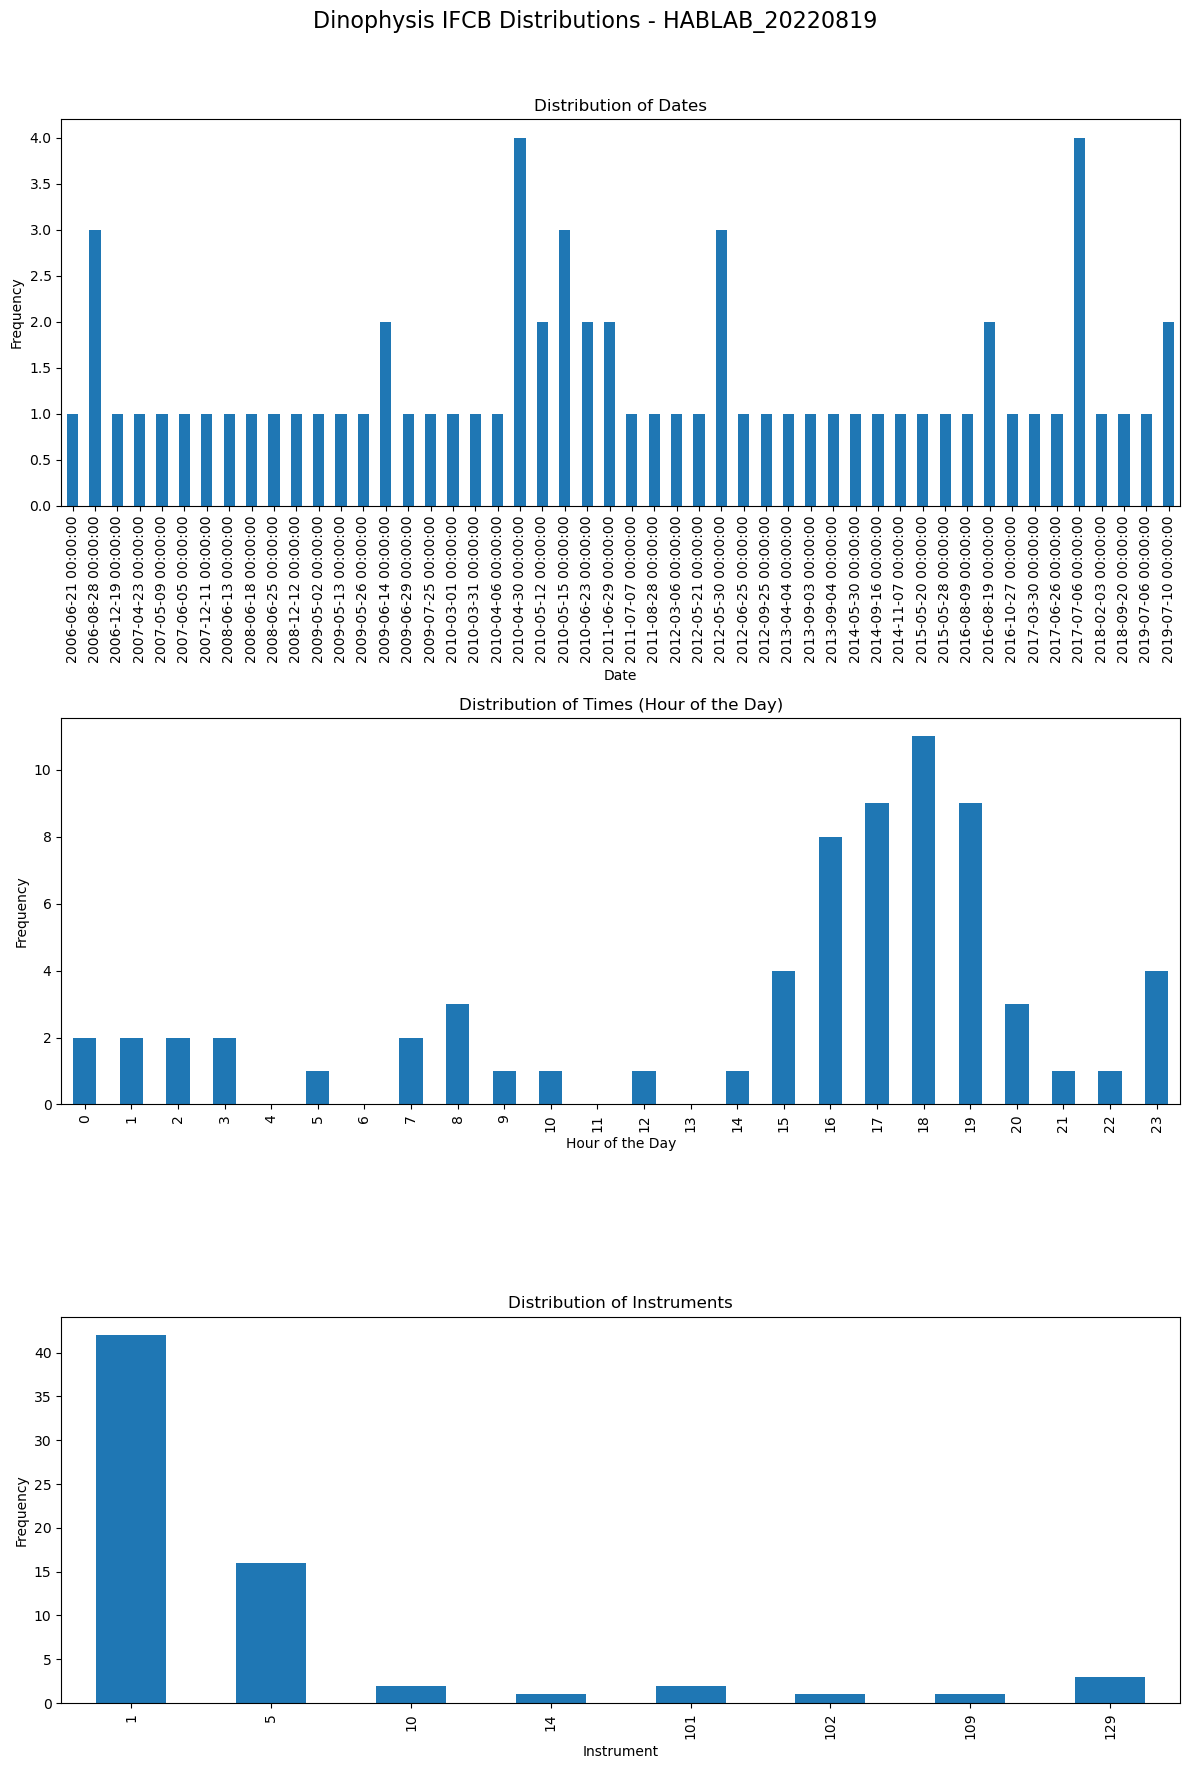

(<Figure size 1200x1800 with 3 Axes>,
 array([<Axes: title={'center': 'Distribution of Dates'}, xlabel='Date', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Times (Hour of the Day)'}, xlabel='Hour of the Day', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Instruments'}, xlabel='Instrument', ylabel='Frequency'>],
       dtype=object))

In [5]:
dino_path = "/Volumes/Vortex/cnn/training_sets/IFCB/HABLAB_20220819/Dinophysis"
dino = process_files_in_directory(dino_path)
print("Unique IFCBs:", dino['Instrument'].unique())
dino_save = "/Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/dinophysis.png"
plot_distributions(dino, suptitle="Dinophysis IFCB Distributions - HABLAB_20220819", save_path=dino_save)

## Dinophysis acuminata

Files that have alternative formats: ['.DS_Store']
Percentage of files that don't match the expected formats: 0.04%
Unique IFCBs: [  1   5  12  10 102 109 101]
Plot saved to /Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/dinophysis_acuminata.png


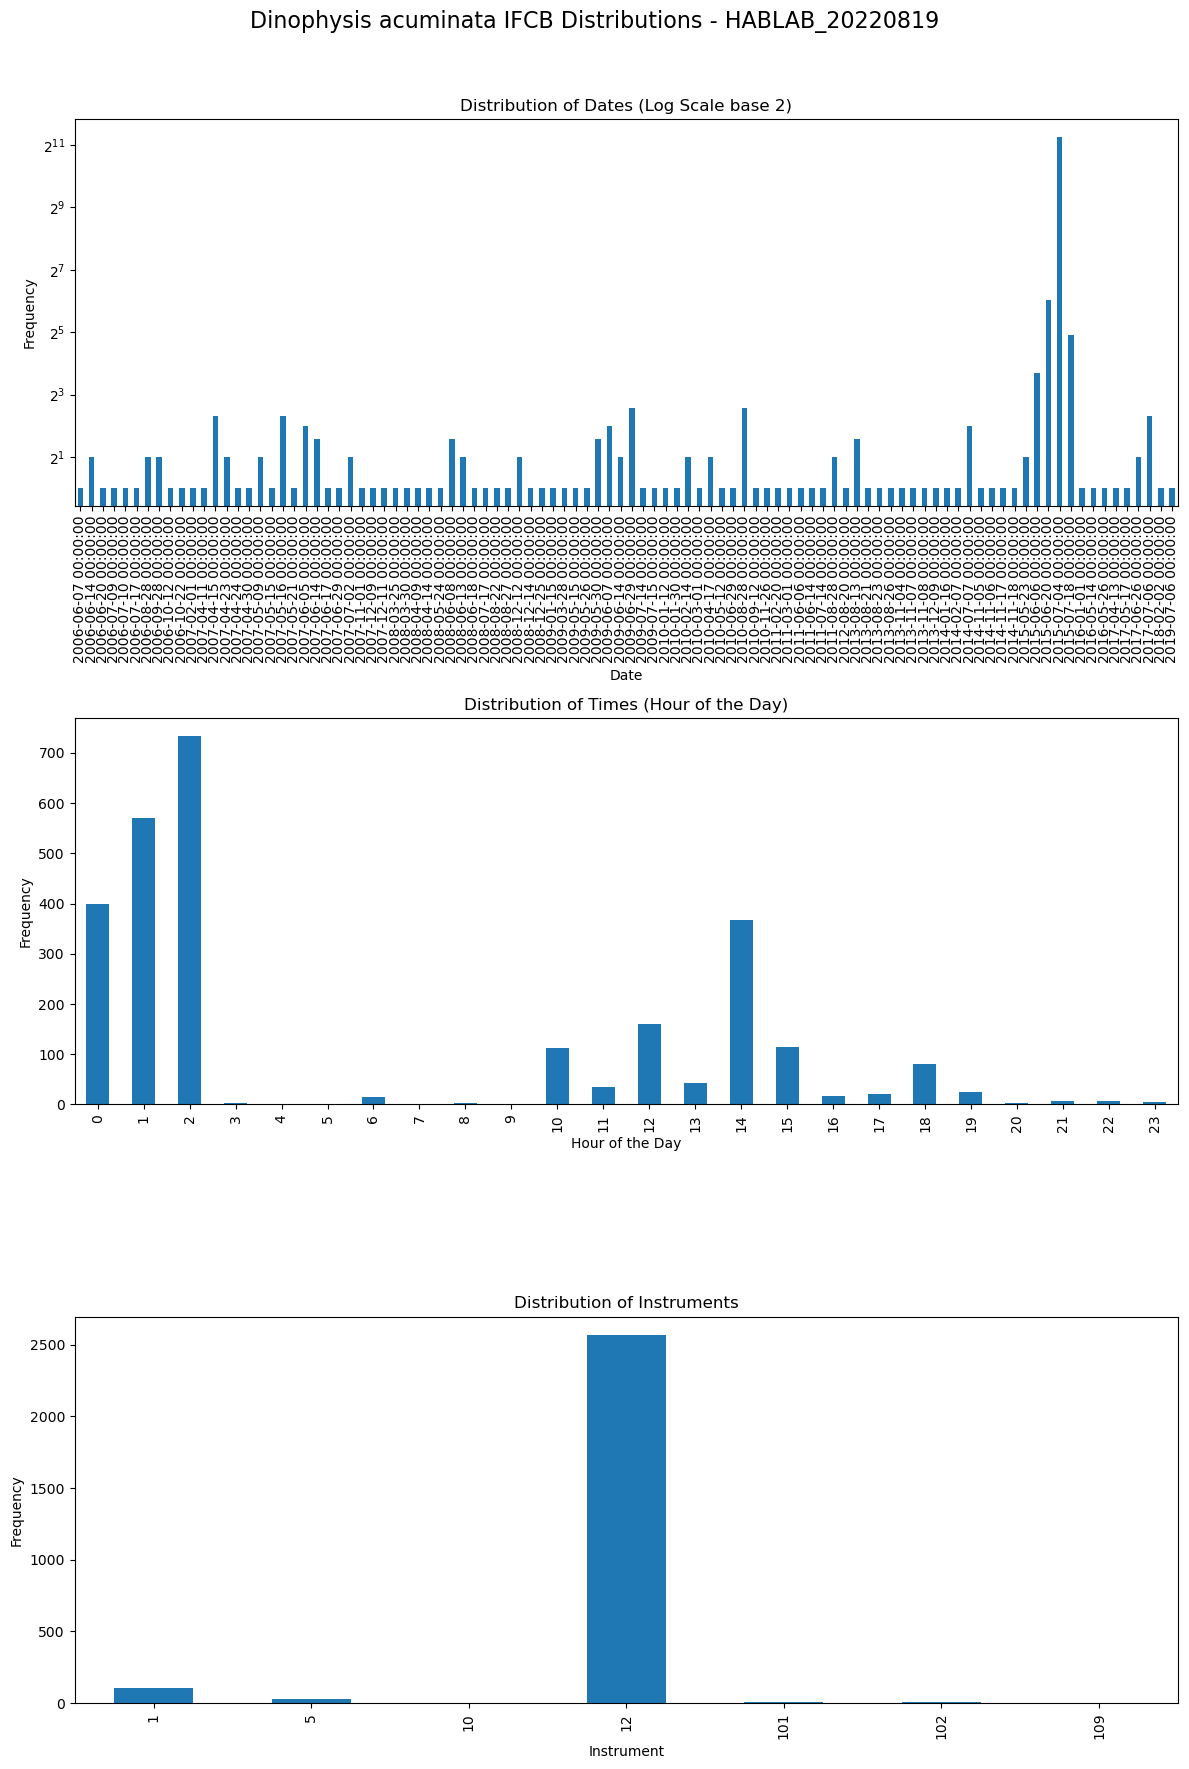

(<Figure size 1200x1800 with 3 Axes>,
 array([<Axes: title={'center': 'Distribution of Dates (Log Scale base 2)'}, xlabel='Date', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Times (Hour of the Day)'}, xlabel='Hour of the Day', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Instruments'}, xlabel='Instrument', ylabel='Frequency'>],
       dtype=object))

In [6]:
dino_acu_path = "/Volumes/Vortex/cnn/training_sets/IFCB/HABLAB_20220819/Dinophysis_acuminata"
dino_acu = process_files_in_directory(dino_acu_path)
print("Unique IFCBs:", dino_acu['Instrument'].unique())
dino_acu_save = "/Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/dinophysis_acuminata.png"
plot_distributions(dino_acu, suptitle="Dinophysis acuminata IFCB Distributions - HABLAB_20220819", save_path=dino_acu_save, log_scale=True, log_base=2)

## Fragillariopsis

not in current working folder

## Gonyaulax

Files that have alternative formats: ['skip', '.DS_Store']
Percentage of files that don't match the expected formats: 0.22%
Unique IFCBs: [  1   5 101 110  10]
Plot saved to /Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/Gonyaulax.png


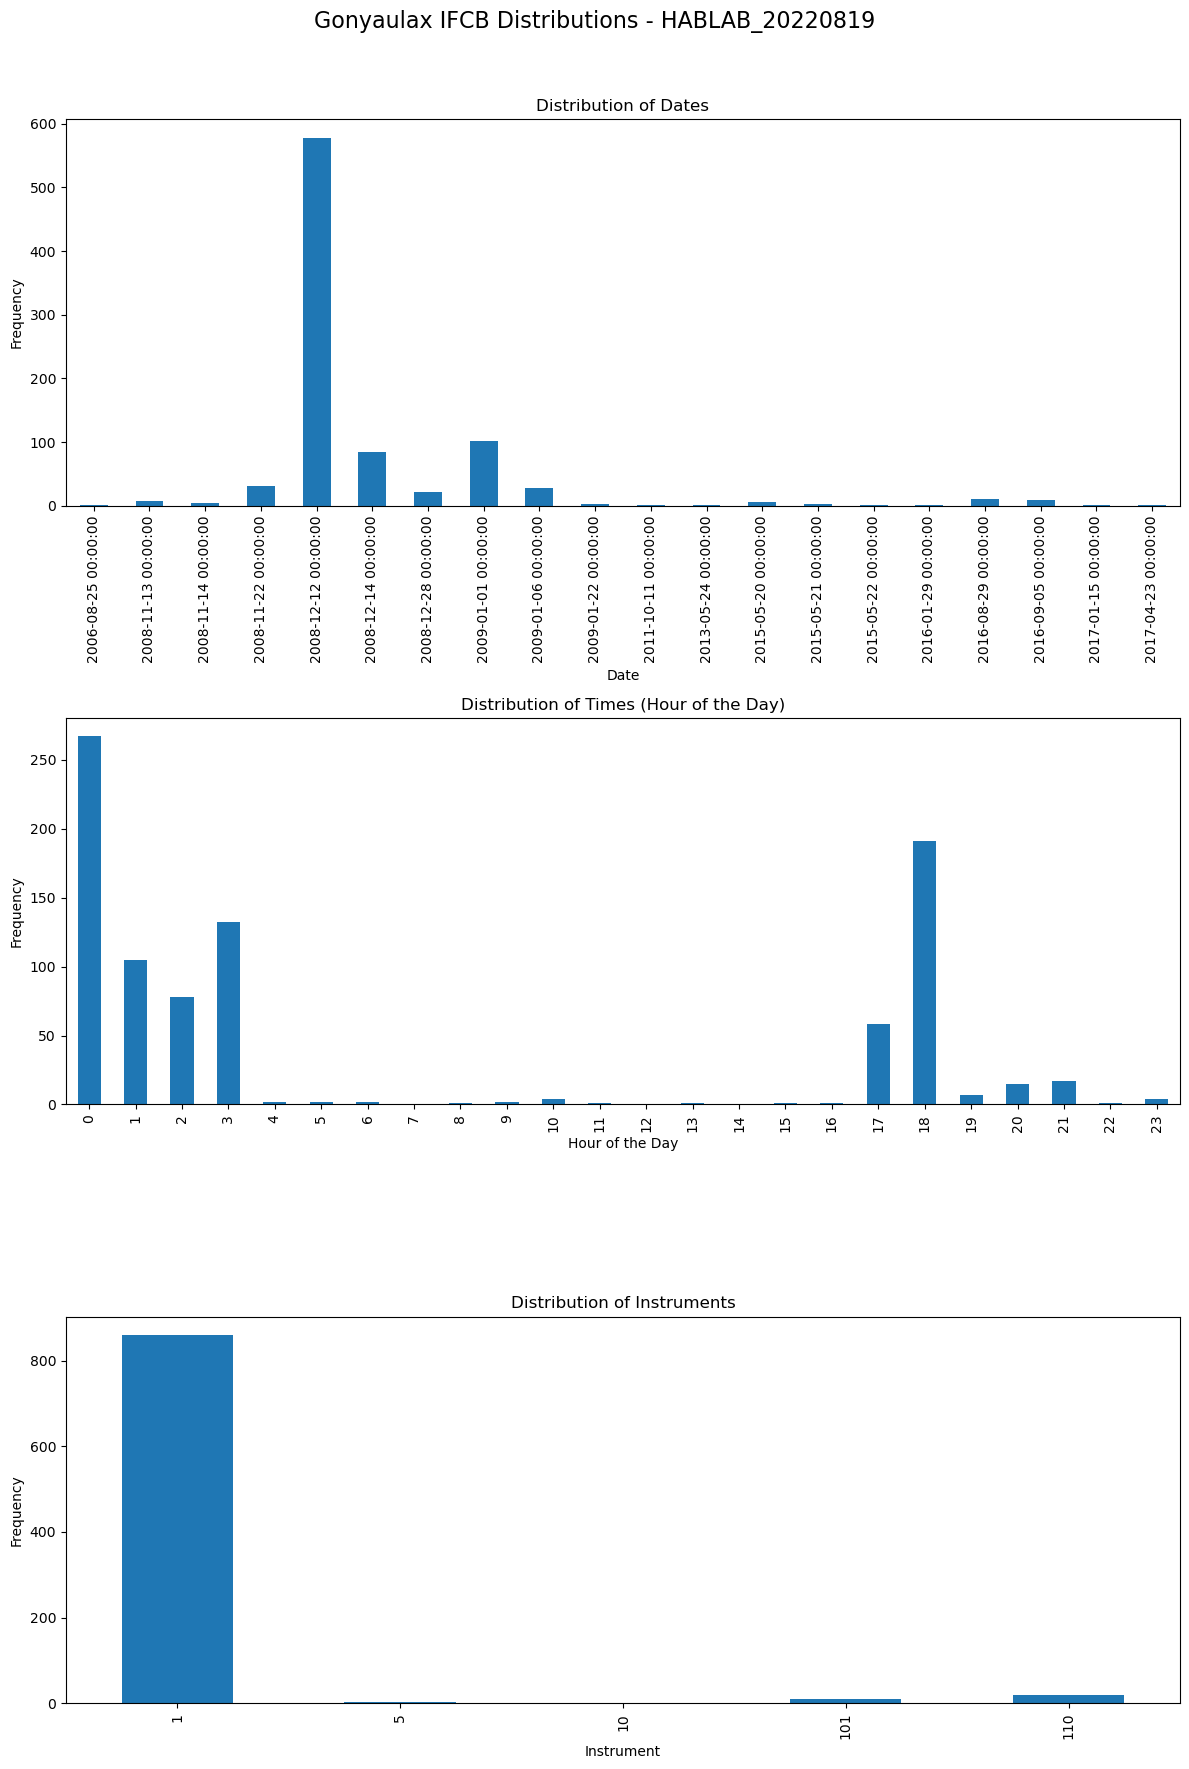

(<Figure size 1200x1800 with 3 Axes>,
 array([<Axes: title={'center': 'Distribution of Dates'}, xlabel='Date', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Times (Hour of the Day)'}, xlabel='Hour of the Day', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Instruments'}, xlabel='Instrument', ylabel='Frequency'>],
       dtype=object))

In [7]:
gonya_path = "/Volumes/Vortex/cnn/training_sets/IFCB/HABLAB_20220819/Gonyaulax"
gonya = process_files_in_directory(gonya_path)
print("Unique IFCBs:", gonya['Instrument'].unique())
gonya_acu_save = "/Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/Gonyaulax.png"
plot_distributions(gonya, suptitle="Gonyaulax IFCB Distributions - HABLAB_20220819", save_path=gonya_acu_save, log_scale=False)

## Kryptoperidinium triquetra

Files that have alternative formats: []
Percentage of files that don't match the expected formats: 0.00%
Unique IFCBs: [  1   5 101  10 127]
Plot saved to /Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/Kryptoperidinium_triquetrum.png


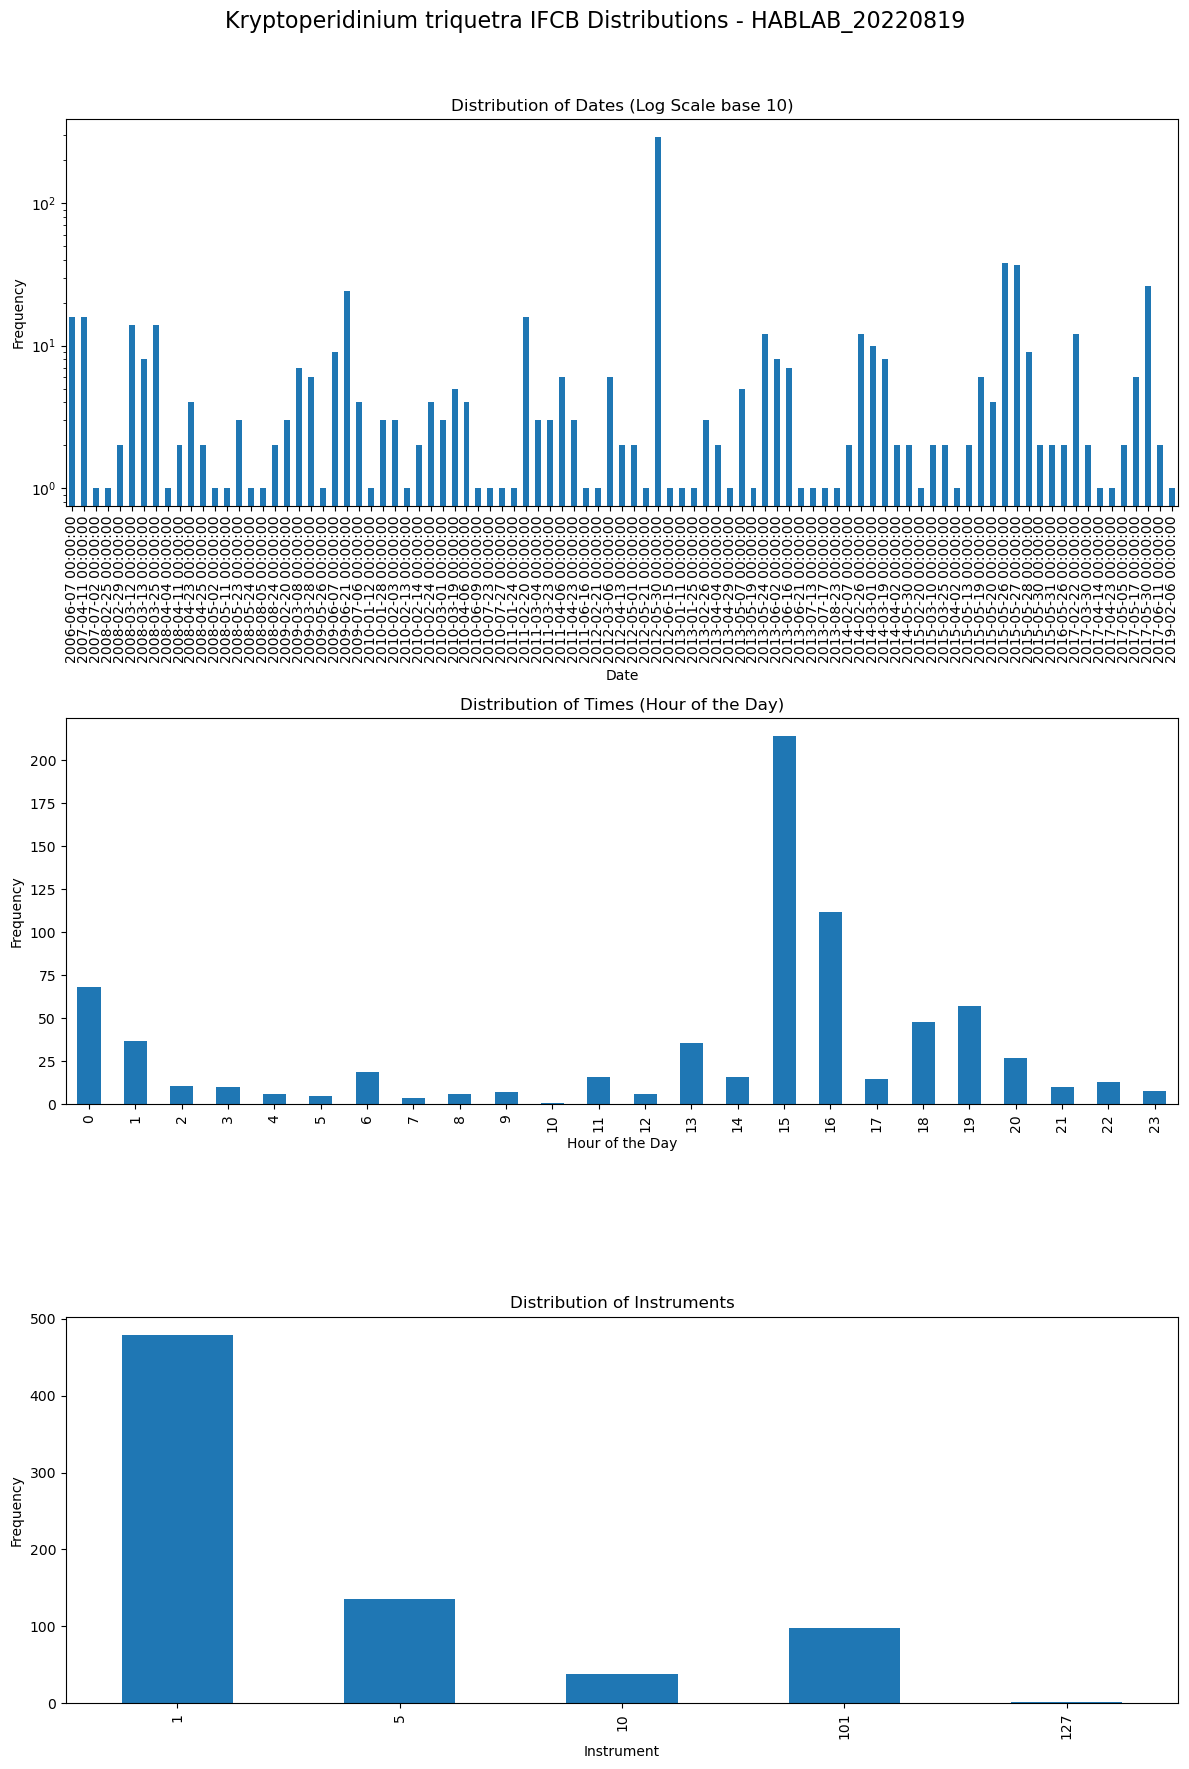

(<Figure size 1200x1800 with 3 Axes>,
 array([<Axes: title={'center': 'Distribution of Dates (Log Scale base 10)'}, xlabel='Date', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Times (Hour of the Day)'}, xlabel='Hour of the Day', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Instruments'}, xlabel='Instrument', ylabel='Frequency'>],
       dtype=object))

In [8]:
kyrpto_tri_path = "/Volumes/Vortex/cnn/training_sets/IFCB/HABLAB_20220819/Kryptoperidinium_triquetrum"
kyrpto_tri = process_files_in_directory(kyrpto_tri_path)
print("Unique IFCBs:", kyrpto_tri['Instrument'].unique())
kyrpto_tri_save = "/Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/Kryptoperidinium_triquetrum.png"
plot_distributions(kyrpto_tri, suptitle="Kryptoperidinium triquetra IFCB Distributions - HABLAB_20220819", save_path=kyrpto_tri_save, log_scale=True)

## Margalefidinium

Files that have alternative formats: ['.DS_Store']
Percentage of files that don't match the expected formats: 0.27%
Unique IFCBs: [123   5]
Plot saved to /Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/Margalefidinium.png


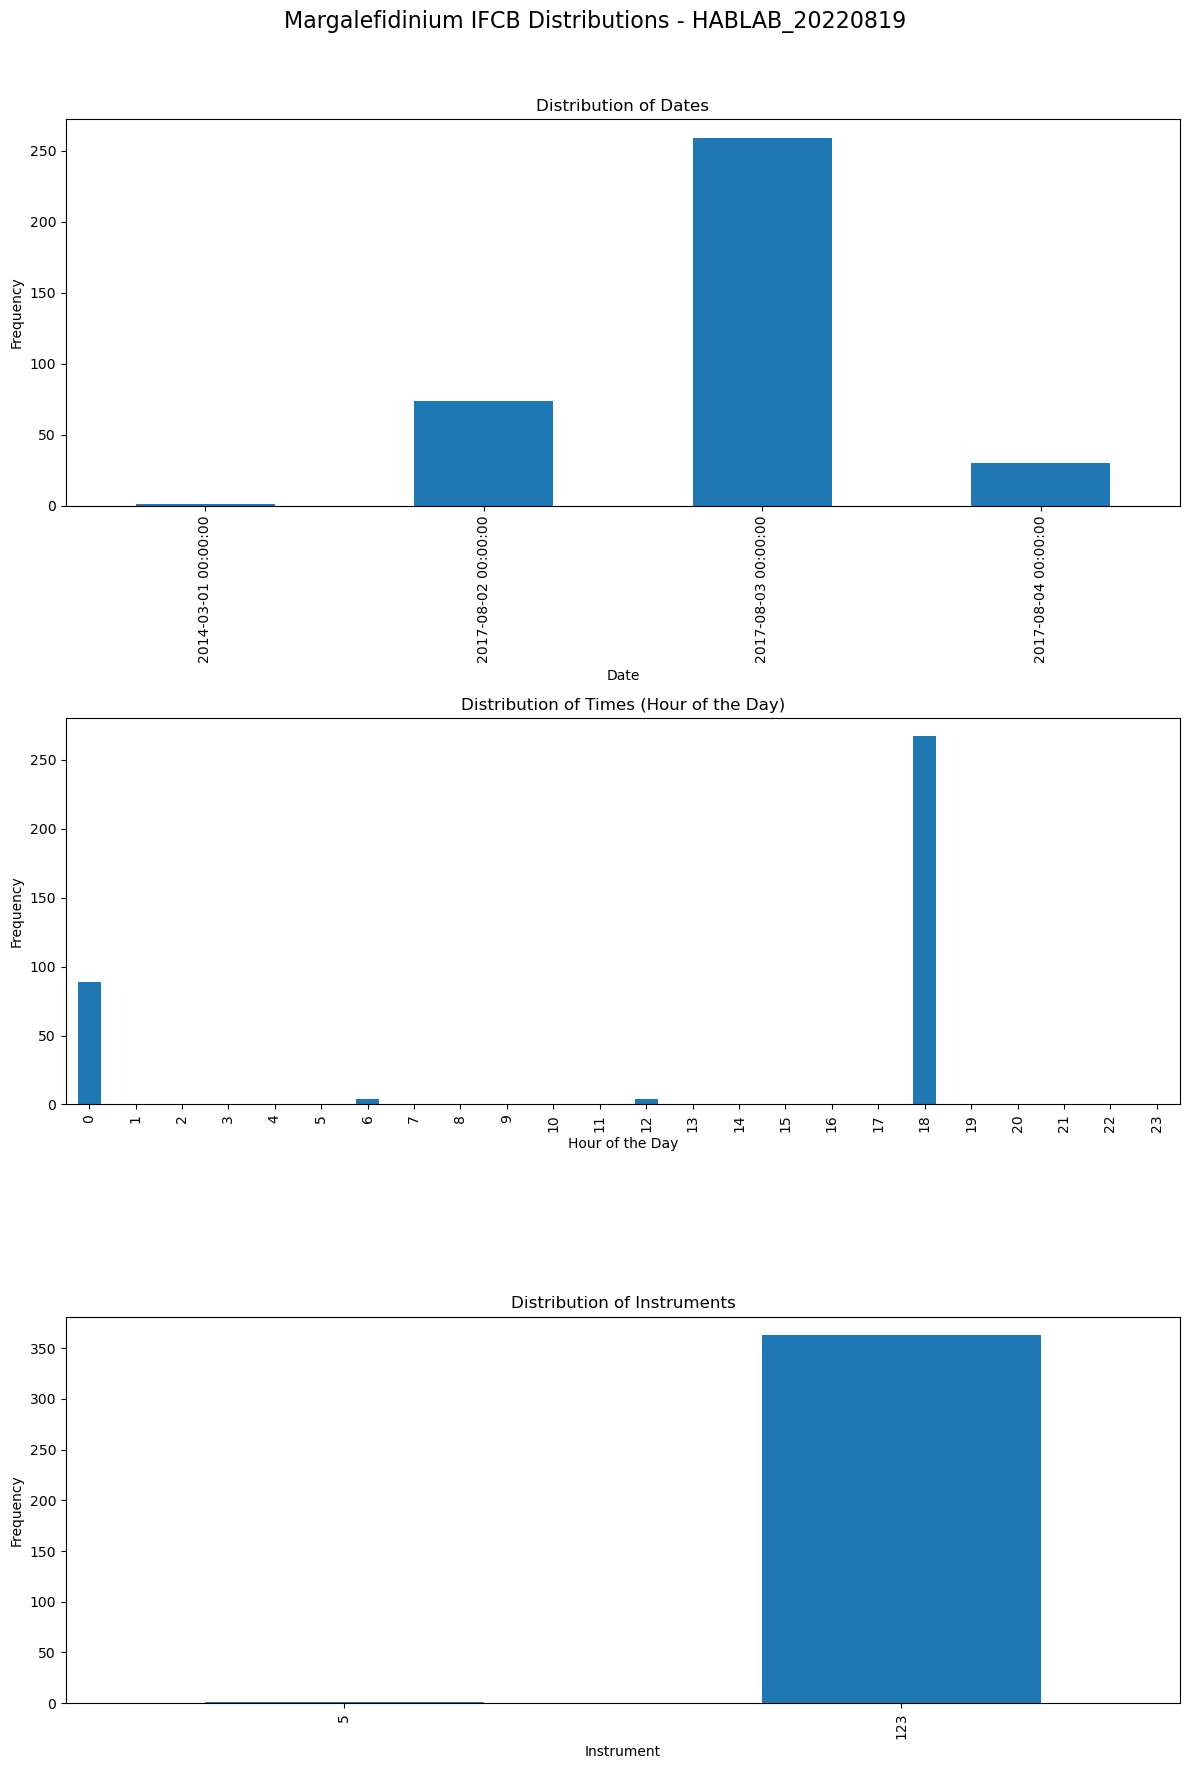

(<Figure size 1200x1800 with 3 Axes>,
 array([<Axes: title={'center': 'Distribution of Dates'}, xlabel='Date', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Times (Hour of the Day)'}, xlabel='Hour of the Day', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Instruments'}, xlabel='Instrument', ylabel='Frequency'>],
       dtype=object))

In [9]:
marg_path = "/Volumes/Vortex/cnn/training_sets/IFCB/HABLAB_20220819/Margalefidinium"
marg = process_files_in_directory(marg_path)
print("Unique IFCBs:",marg['Instrument'].unique())
marg_save = "/Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/Margalefidinium.png"
plot_distributions(marg, suptitle="Margalefidinium IFCB Distributions - HABLAB_20220819", save_path=marg_save, log_scale=False)

## Mesodinium

### Trying to figure out how to better bin these dates so it is readable?

Files that have alternative formats: []
Percentage of files that don't match the expected formats: 0.00%
Unique IFCBs: [  1   5  10  14 101 102 109 127 129]
Plot saved to /Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/Mesodinium.png


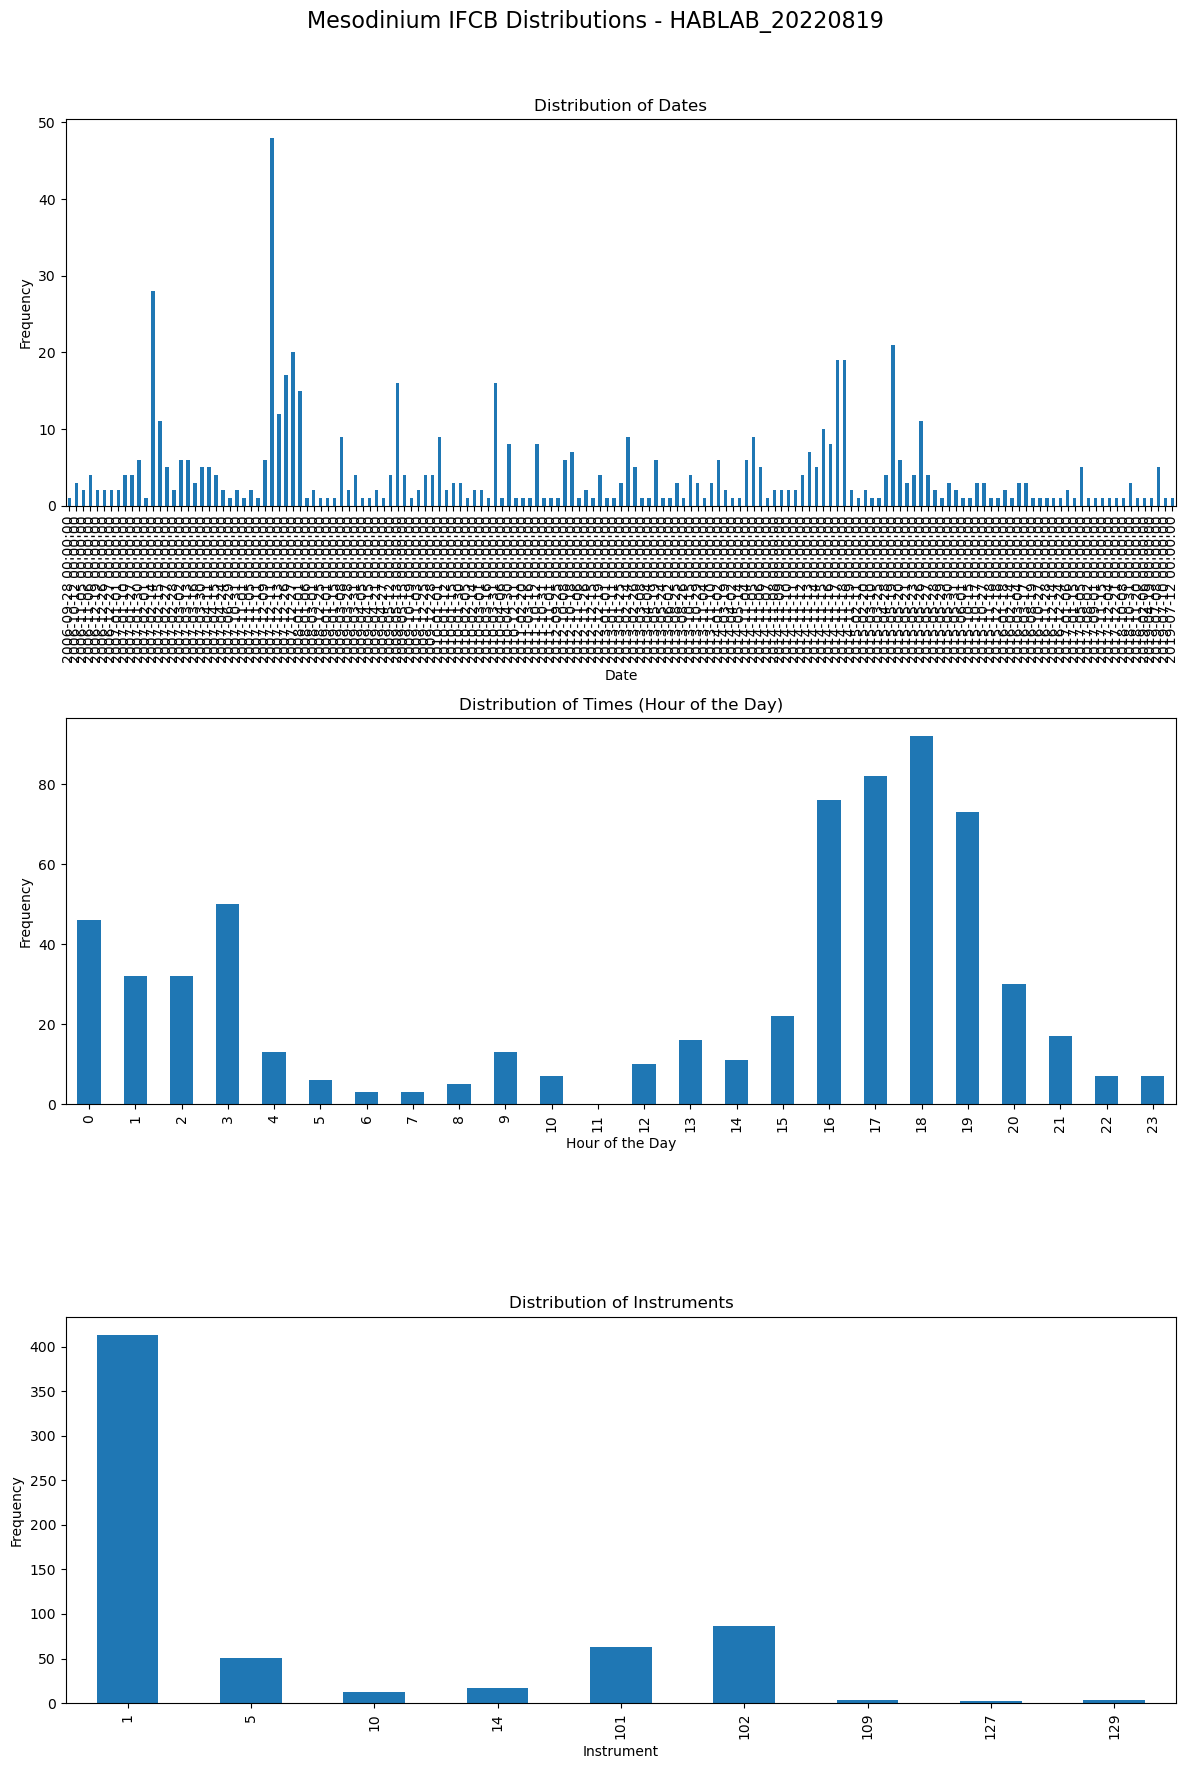

In [10]:
meso_path = "/Volumes/Vortex/cnn/training_sets/IFCB/HABLAB_20220819/Mesodinium"
meso = process_files_in_directory(meso_path)
print("Unique IFCBs:", meso['Instrument'].unique())
meso_save = "/Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/Mesodinium.png"

fig, axs = plot_distributions(meso, suptitle="Mesodinium IFCB Distributions - HABLAB_20220819", save_path=meso_save, log_scale=False)

# # Display every other x tickmark in the first subplot
# n = 2  # Keeps every 2nd label
# [l.set_visible(False) for (i, l) in enumerate(axs[0].xaxis.get_ticklabels()) if i % n != 0]


## Rhizosolenia

Files that have alternative formats: []
Percentage of files that don't match the expected formats: 0.00%
Unique IFCBs: [  5   1  14  10 101 102 127 109 115]
Plot saved to /Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/Rhizosolenia.png


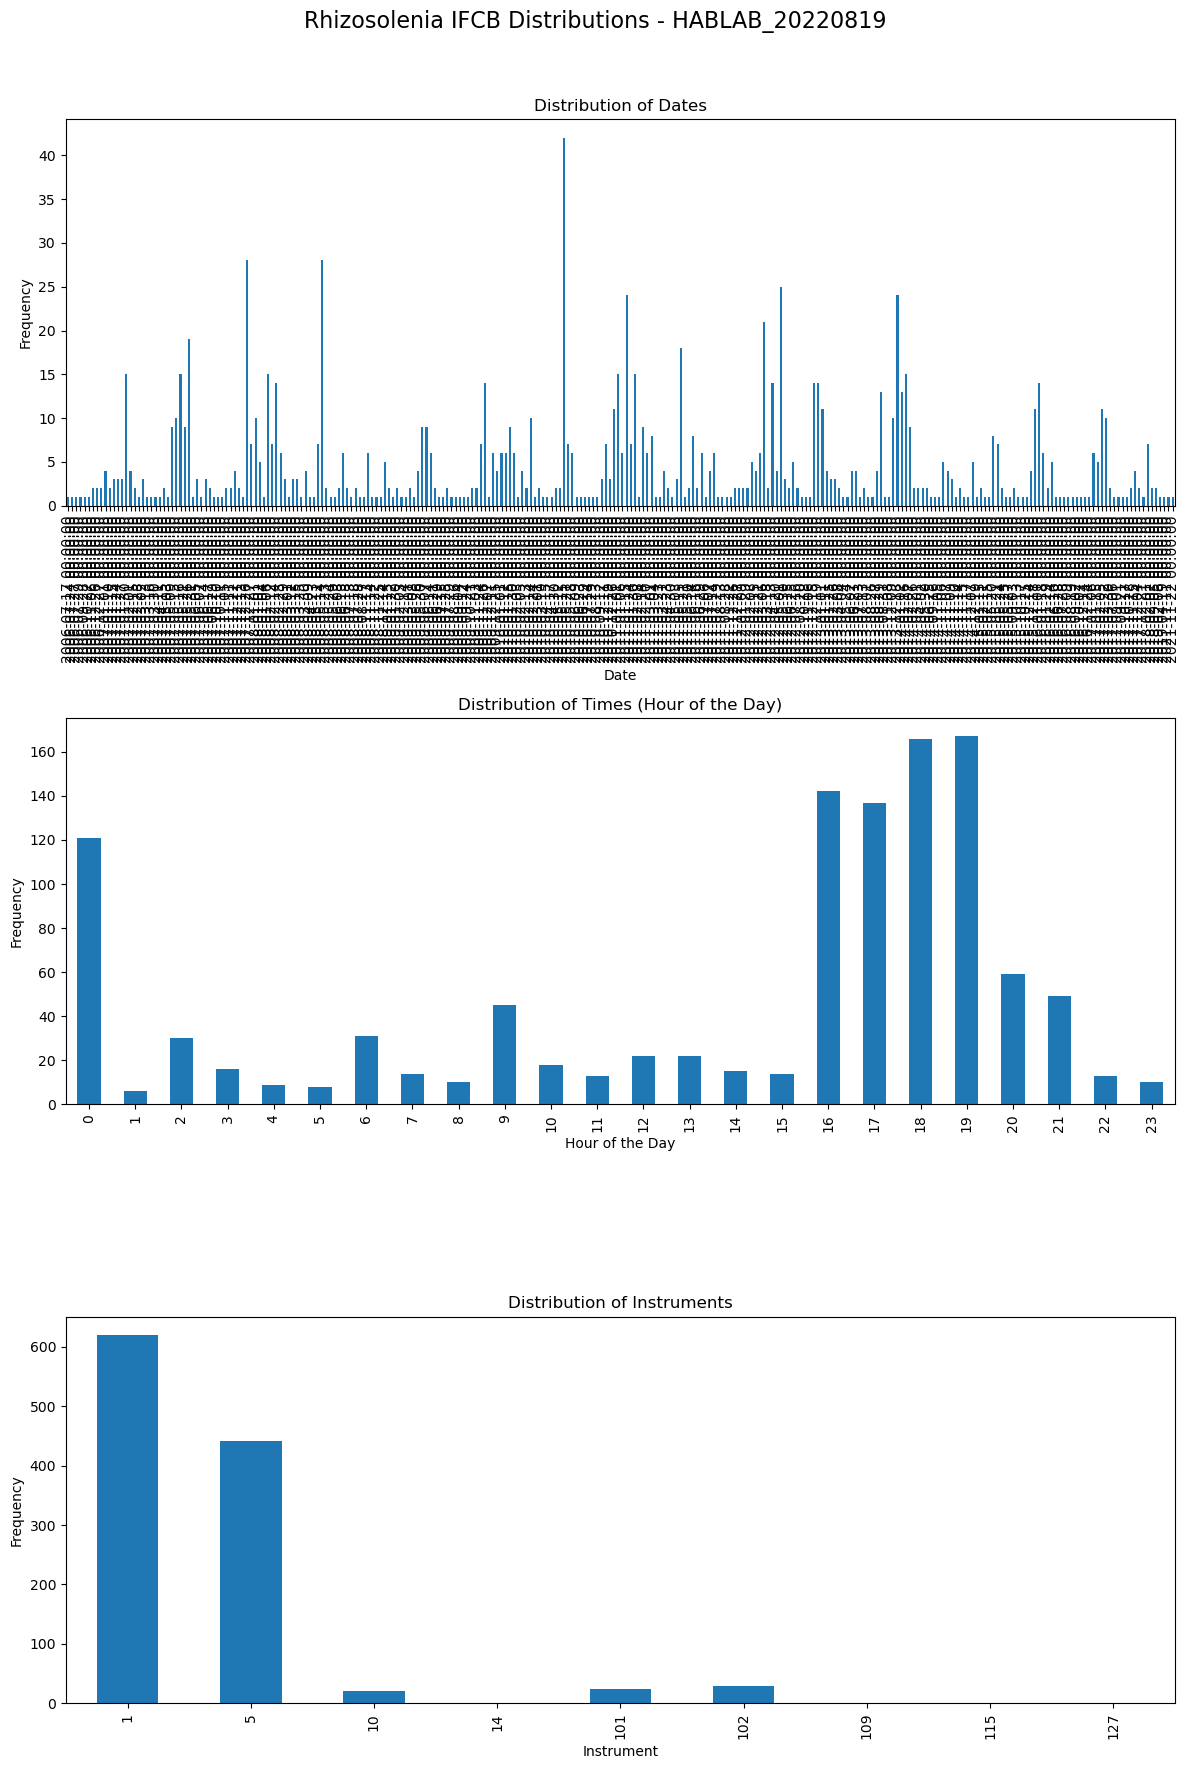

(<Figure size 1200x1800 with 3 Axes>,
 array([<Axes: title={'center': 'Distribution of Dates'}, xlabel='Date', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Times (Hour of the Day)'}, xlabel='Hour of the Day', ylabel='Frequency'>,
        <Axes: title={'center': 'Distribution of Instruments'}, xlabel='Instrument', ylabel='Frequency'>],
       dtype=object))

In [11]:
rhizo_path = "/Volumes/Vortex/cnn/training_sets/IFCB/HABLAB_20220819/Rhizosolenia"
rhizo = process_files_in_directory(rhizo_path)
print("Unique IFCBs:",rhizo['Instrument'].unique())
rhizo_save = "/Users/cristianswift/Desktop/WHOI/2024-Fall-Research/IFCB-Temporal-Distributions/IFCB-distributions/Rhizosolenia.png"
plot_distributions(rhizo, suptitle="Rhizosolenia IFCB Distributions - HABLAB_20220819", save_path=rhizo_save, log_scale=False)